<a href="https://colab.research.google.com/github/bratadeepsarkar123/Winter-projects-25-26/blob/main/EEG-Based%20P300%20Speller/assignments/assignment_2/240285_bratadeep_EEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install MNE library (if not already installed)
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 56.2 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import numpy as np
import scipy.io
import mne
import matplotlib.pyplot as plt
from google.colab import drive

# 1. Mount Google Drive
# Mount Google Drive to access the dataset.
# (Example: drive.mount('/content/drive'))

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. Load the Data
# Load the '.mat' file using scipy.io.loadmat.
# (Example: file_path = '/content/drive/My Drive/eea/Dataset/Subject_A_Train.mat'; mat_data = scipy.io.loadmat(file_path))

file_path = '/content/drive/MyDrive/BCI_Comp_III_Wads_2004/Subject_A_Test.mat'
mat_data = scipy.io.loadmat(file_path)
mat_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Signal', 'TargetChar', 'Flashing', 'StimulusCode', 'StimulusType'])

In [ ]:
# 3. Extract & Reshape EEG Signal
# The raw signal is typically 3D (Epochs, Samples, Channels).
# Reshape it into 2D (Channels, Total_Samples) for MNE.
# This involves concatenating epochs and transposing the data.
# Convert the units from microvolts (uV) to Volts (V).


In [ ]:
mat_data['Signal'].shape

(85, 7794, 64)

In [ ]:
eeg_signal_v_3d = mat_data['Signal']
n_epochs, n_samples, n_channels = eeg_signal_v_3d.shape

eeg_signal_v_2d = eeg_signal_v_3d.reshape(n_epochs * n_samples, n_channels)
eeg_signal_v = eeg_signal_v_2d.T
print(eeg_signal_v.shape)

eeg_signal = eeg_signal_v * 1e-6  # μV to V = voltage * 1e-6

(64, 662490)


In [ ]:
# 4. Process Marker Channels (e.g., Flashing & StimulusCode)
# These markers are usually 3D or 2D and need to be flattened to 1D to match the continuous signal length.
# Ensure the lengths of the processed signal and markers are consistent.

In [ ]:
print(mat_data['Flashing'].shape)
print(mat_data['StimulusCode'].shape)
print(mat_data['StimulusType'].shape)

(85, 7794)
(85, 7794)
(85, 7794)


In [ ]:
flashing_flat = mat_data['Flashing'].flatten()
stimuluscode_flat = mat_data['StimulusCode'].flatten()
stimulustype_flat = mat_data['StimulusType'].flatten()

print(f"Flashing marker flattened shape: {flashing_flat.shape}")
print(f"StimulusCode marker flattened shape: {stimuluscode_flat.shape}")
print(f"StimulusType marker flattened shape: {stimulustype_flat.shape}")
print('\n')


total_samples = n_epochs * n_samples
print(f"Total samples in EEG signal: {total_samples}")
print(f"Flashing length matches EEG signal length: {flashing_flat.shape[0] == total_samples}")
print(f"StimulusCode length matches EEG signal length: {stimuluscode_flat.shape[0] == total_samples}")
print(f"StimulusType length matches EEG signal length: {stimulustype_flat.shape[0] == total_samples}")


Flashing marker flattened shape: (662490,)
StimulusCode marker flattened shape: (662490,)
StimulusType marker flattened shape: (662490,)


Total samples in EEG signal: 662490
Flashing length matches EEG signal length: True
StimulusCode length matches EEG signal length: True
StimulusType length matches EEG signal length: True


In [ ]:
# 5. Construct MNE Events
# Using the processed marker channels (e.g., 'Flashing' for onset detection and 'StimulusCode' for event IDs),
# detect event onsets (e.g., rising edges of the 'Flashing' signal).
# Then, create an MNE-compatible events array: (onset_index, 0, event_id).

In [ ]:

flashing_diff = np.diff(flashing_flat)
onset_indices = np.where(flashing_diff == 1)[0] + 1
print(onset_indices.shape)
print('\n')

event_id = stimuluscode_flat[onset_indices]
print(event_id.shape)
print('\n')

events = np.column_stack((onset_indices, np.zeros(len(onset_indices), dtype=int), event_id))

print(f"Detected {len(events)} events.")
print("First 10 events:\n", events[:10])

(15299,)


(15299,)


Detected 15299 events.
First 10 events:
 [[ 42.   0.  11.]
 [ 84.   0.   3.]
 [126.   0.  10.]
 [168.   0.   9.]
 [210.   0.   7.]
 [252.   0.   8.]
 [294.   0.   2.]
 [336.   0.   6.]
 [378.   0.   5.]
 [420.   0.   4.]]


In [ ]:
# 6. Create MNE Raw Object
# Define the sampling frequency (sfreq), channel names (ch_names), and channel types (ch_types).
# Then, create an MNE 'info' object.
# Finally, create an 'mne.io.RawArray' object from the reshaped EEG signal and the 'info' object.
# Optionally, add the events as a 'stim' channel to the raw object.



In [ ]:
# Define sampling frequency (sfreq)
sfreq = 240

# Define channel names (ch_names)

ch_names = [f'EEG {i:03d}' for i in range(1, n_channels + 1)]

# Define channel types (ch_types)
ch_types = ['eeg'] * n_channels

# Create MNE 'info' object
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

# Create an 'mne.io.RawArray' object
raw = mne.io.RawArray(eeg_signal, info)

print(raw)
print(raw.info)

Creating RawArray with float64 data, n_channels=64, n_times=662490
    Range : 0 ... 662489 =      0.000 ...  2760.371 secs
Ready.
<RawArray | 64 x 662490 (2760.4 s), ~323.5 MiB, data loaded>
<Info | 7 non-empty values
 bads: []
 ch_names: EEG 001, EEG 002, EEG 003, EEG 004, EEG 005, EEG 006, EEG 007, ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 120.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 240.0 Hz
>


In [ ]:
## https://mne.tools/stable/auto_tutorials/preprocessing/30_filtering_resampling.html#

Using matplotlib as 2D backend.


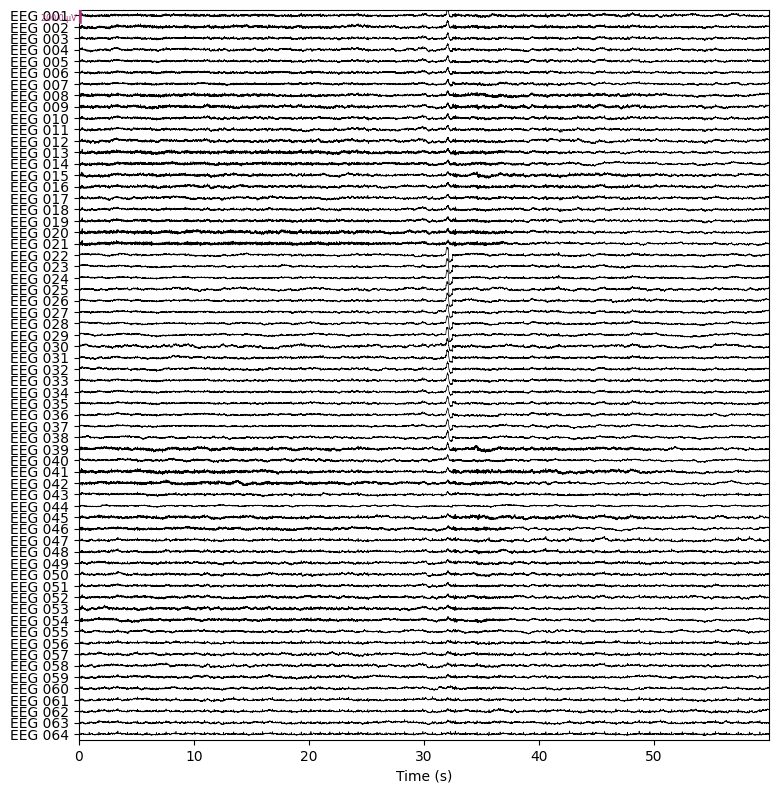

In [ ]:
# 1. Visualize Data BEFORE Filtering (Power Spectral Density)
# Compute and plot the Power Spectral Density (PSD) of the raw data
# to observe the frequency content before any filtering (e.g., raw.compute_psd().plot()).

fig = raw.plot(duration=60, proj=False, n_channels=64, scalings=dict(eeg=100e-6),
               show_scrollbars = False)


Effective window size : 8.533 (s)
Plotting power spectral density (dB=True).


/tmp/ipython-input-859992417.py:3: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


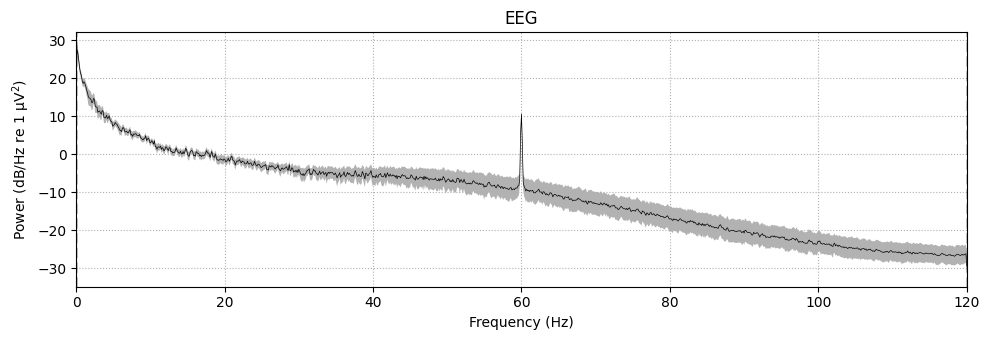

In [ ]:
# Compute and plot the Power Spectral Density
raw.compute_psd(picks='eeg', fmax=raw.info['sfreq'] /2.0).plot(picks='eeg', exclude='bads', show=True,  average=True, spatial_colors=True)
plt.tight_layout()
plt.show()


Effective window size : 8.533 (s)
Plotting power spectral density (dB=True).


/tmp/ipython-input-3605353803.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


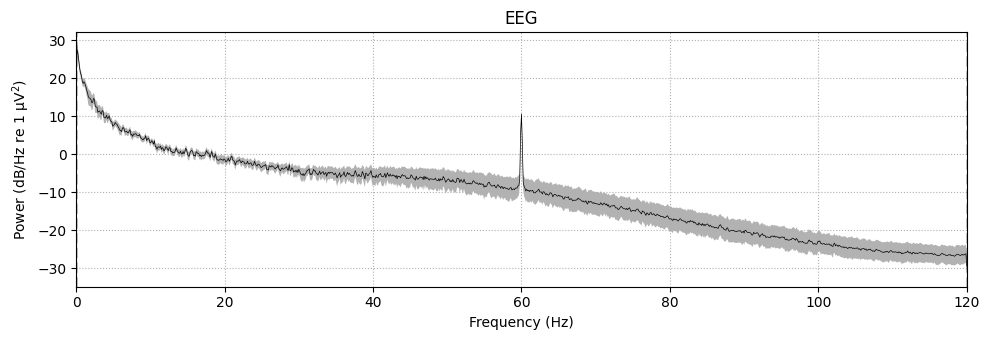

In [ ]:
# 2. Apply Band-pass Filter
# Apply a band-pass filter to the raw data (e.g., 0.1Hz - 20Hz) to remove unwanted frequencies.
# Consider using an FIR filter design (e.g., raw.filter(l_freq=..., h_freq=..., fir_design='firwin')).

# Compute and plot the Power Spectral Density
raw.compute_psd(picks='eeg', fmax=raw.info['sfreq'] /2.0).plot(picks='eeg', exclude='bads', show=True,  average=True, spatial_colors=True)
plt.tight_layout()
plt.show()


In [ ]:
# 3. Downsample the Data
# Downsample the data to a lower sampling rate (e.g., from 240Hz to 120Hz).
# MNE's resample function automatically handles anti-aliasing (e.g., raw.resample(sfreq=...)).

# Downsample the data to 120 Hz
raw.resample(sfreq=120, verbose=False)

print(raw)
print(f"New sampling frequency: {raw.info['sfreq']} Hz")

<RawArray | 64 x 331245 (2760.4 s), ~161.8 MiB, data loaded>
New sampling frequency: 120.0 Hz


Effective window size : 17.067 (s)
Plotting power spectral density (dB=True).


/tmp/ipython-input-2084705647.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


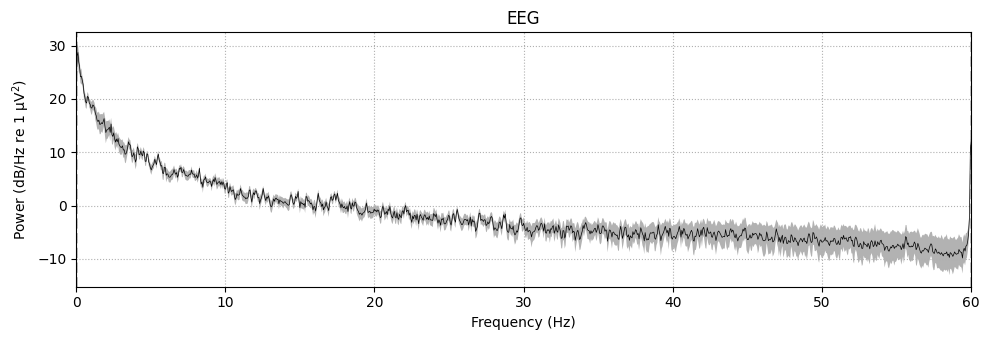

In [ ]:
# 4. Visualize Data AFTER Filtering
# Compute and plot the PSD of the filtered and downsampled data
# to verify the effectiveness of the filtering (e.g., raw.compute_psd().plot()).

raw.compute_psd(picks='eeg', fmax=raw.info['sfreq'] /2.0).plot(picks='eeg', exclude='bads', show=True,  average=True, spatial_colors=True)
plt.tight_layout()
plt.show()


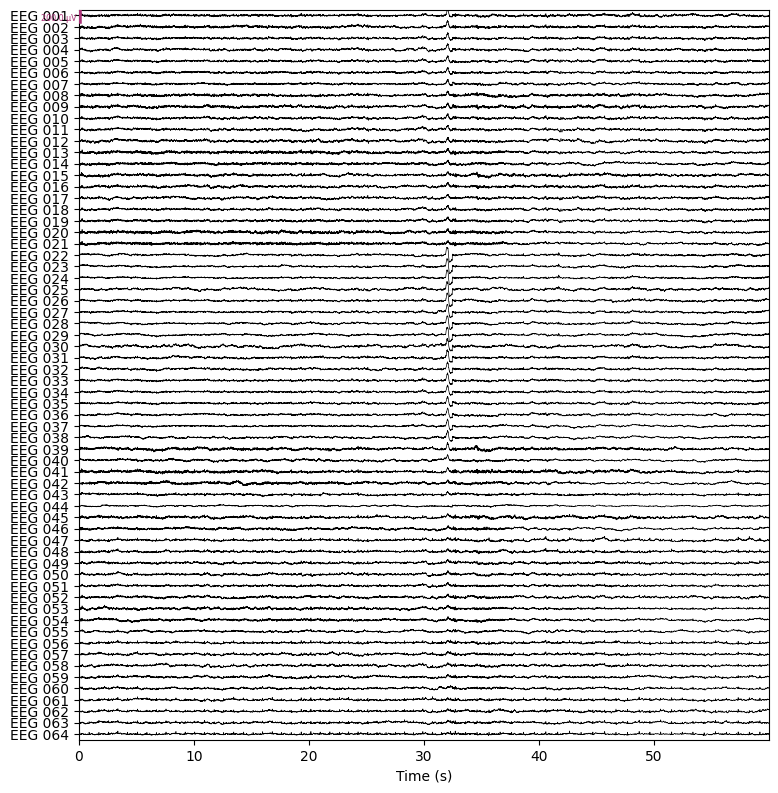

In [ ]:
fig = raw.plot(duration=60, proj=False, n_channels=64, scalings=dict(eeg=100e-6),
               show_scrollbars = False)

In [ ]:
# https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html#

In [ ]:
# 1. Assign Standard Channel Names and Montage
# The initial channel names might be generic (e.g., EEG_1, EEG_2).
# Rename the EEG channels to standard names (e.g., 'FC5', 'Cz', 'Pz')
# that correspond to a known montage (e.g., 'standard_1005' or 'standard_1020').
# This is crucial for visualizing components topologically.
# Then, set a standard montage using mne.channels.make_standard_montage.

montage_1020 = mne.channels.make_standard_montage("standard_1020")
standard_ch_names = montage_1020.ch_names
new_ch_names = standard_ch_names[:n_channels]
current_ch_names = raw.info['ch_names']
channel_mapping = dict(zip(current_ch_names, new_ch_names))
raw.rename_channels(channel_mapping)
raw.set_montage(montage_1020)
print("Channels renamed successfully. First 10 new channel names:", raw.info['ch_names'][:10])

Channels renamed successfully. First 10 new channel names: ['Fp1', 'Fpz', 'Fp2', 'AF9', 'AF7', 'AF5', 'AF3', 'AF1', 'AFz', 'AF2']


In [ ]:
# 2. Initialize and Fit ICA
# Initialize an ICA object (e.g., mne.preprocessing.ICA) specifying parameters like n_components and random_state.
# Then, fit the ICA model to the raw data, often applying a high-pass filter (>1Hz) for better component separation.
# (Example: ica.fit(raw, reject=dict(eeg=...)))

from mne.preprocessing import ICA

# Initialize ICA
ica = ICA(n_components = 15, max_iter="auto", random_state=97)

# fit ICA on high-pass filtered data
raw_for_ica = raw.copy().filter(l_freq=1., h_freq=None, fir_design='firwin', verbose=False)

# Fit ICA to the high-pass filtered raw data
ica.fit(raw_for_ica, reject=dict(eeg=100e-6))

print("ICA model fitted successfully.")
print(ica)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
    Rejecting  epoch based on EEG : ['F4', 'F6', 'F8', 'F10', 'FT9', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4']
Artifact detected in [3600, 3840]
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF9', 'AF7', 'AF5', 'AF3', 'AFz', 'AF2', 'F4', 'F6', 'F8', 'F10', 'FT9', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'FT10', 'T9', 'T7', 'C5', 'C3']
Artifact detected in [3840, 4080]
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF9', 'AF7', 'AF5', 'AF3', 'AF1', 'AFz', 'AF2', 'AF4', 'AF6', 'AF8', 'AF10', 'F9', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'F10', 'FT9', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'FT10', 'T9', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'T8', 'T10', 'TP9', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'TP10', 'P9', 'P7', 'P5', 'P3', 'P1', 'Pz']
Artifact detected in [7680, 7920]
    Rejecting  e

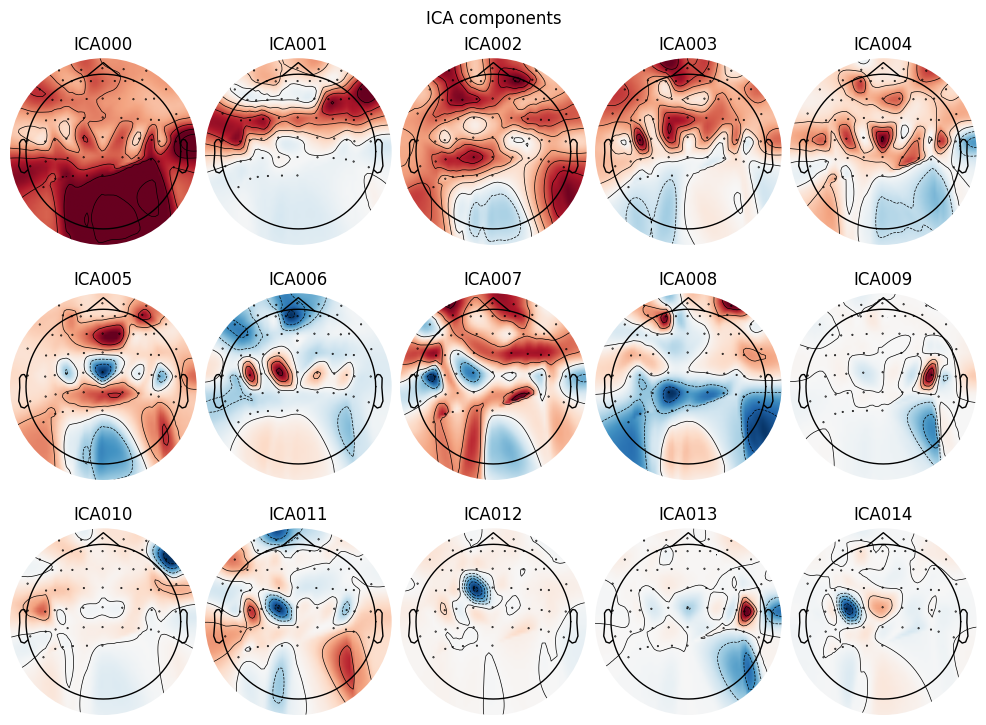

In [ ]:
# 3. Plot ICA Components
# After fitting, plot the ICA components to visually inspect them for artifacts like eye blinks or muscle activity.
# (Example: ica.plot_components())

fig = ica.plot_components()

In [ ]:
# 1. Identify and Exclude Artifact Components
# Based on visual inspection of the ICA components (from the previous step),
# identify components that clearly represent artifacts (e.g., eye blinks, eye movements, muscle activity).
# Then, set the 'exclude' attribute of the ICA object with the indices of these artifact components.

# It seems to me components 0,2, and 3 are disturbing, possibly eye blink
artifact_components = [0, 2, 3]
ica.exclude = artifact_components

print(f"ICA components excluded: {ica.exclude}")

ICA components excluded: [0, 2, 3]


In [ ]:
# 2. Apply ICA to Remove Artifacts
# Apply the trained ICA model with the excluded components to the raw data.
# This will project the data back into sensor space with the identified artifact components removed.
# (Example: ica.apply(raw))

# Applying the ICA solution to the raw data, excluding the identified artifact components
ica.apply(raw)

print("ICA artifact removal applied to raw data.")

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 3 ICA components
    Projecting back using 64 PCA components
ICA artifact removal applied to raw data.


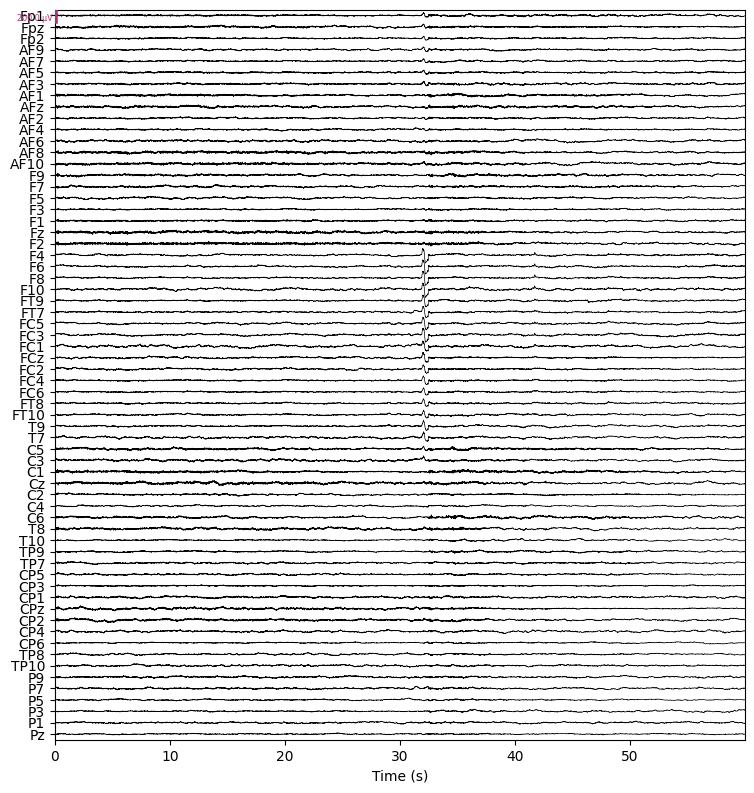

In [ ]:
# 3. Visualize Clean Data
# To verify the artifact removal, plot a segment of the cleaned raw data.
# Observe if the previously identified artifacts (like large eye blinks) have been successfully suppressed.
# (Example: raw.plot(n_channels=..., duration=..., title='Data AFTER removing Blinks'))

fig = raw.plot(n_channels=len(raw.info['ch_names']), duration=60, scalings=dict(eeg=100e-6),
               title='Data AFTER removing Artifacts with ICA', proj=False, show_scrollbars = False)


In [ ]:
# 1. Prepare Events for Epoching
# Load and process the 'StimulusType' data to assign labels (e.g., Target/Non-Target)
# to the event onsets identified earlier. Create a new MNE-compatible events array
# where the third column represents the event ID (e.g., 1 for Non-Target, 2 for Target).
# Ensure the event IDs are integers.

# Get the StimulusType values at the detected onset indices
stimulus_type = stimulustype_flat[onset_indices]

# Create a new event_id based on StimulusType
new_event_ids = np.zeros_like(stimulus_type, dtype=int)
new_event_ids[stimulus_type == 0] = 1  # Non-Target
new_event_ids[stimulus_type == 1] = 2  # Target

# Create the new MNE-compatible events array: (onset_index, 0, event_id)
events_mne = np.column_stack((onset_indices, np.zeros(len(onset_indices), dtype=int), new_event_ids))

print(f"Prepared  {len(events_mne)}  MNE events.")
print("First 10 prepared MNE events (onset_index, 0, event_id):\n", events_mne[:10])

Prepared  15299  MNE events.
First 10 prepared MNE events (onset_index, 0, event_id):
 [[ 42   0   1]
 [ 84   0   1]
 [126   0   1]
 [168   0   1]
 [210   0   2]
 [252   0   1]
 [294   0   1]
 [336   0   1]
 [378   0   2]
 [420   0   1]]


In [ ]:
# 2. Define Event IDs Dictionary
# Create a dictionary mapping descriptive event names (e.g., 'Non-Target', 'Target') to their corresponding integer IDs.

event_id_dict = {'Non-Target': 1, 'Target': 2}
print("Event ID Dictionary:", event_id_dict)

Event ID Dictionary: {'Non-Target': 1, 'Target': 2}


In [ ]:
# 3. Create Epochs
# Use mne.Epochs to segment the continuous raw data around the events.
# Define the epoch time window (e.g., tmin, tmax), set a baseline correction,
# and preload the data into memory.

# Define epoch parameters
tmin = -0.1  # Start of epoch (seconds before event onset)
tmax = 0.8   # End of epoch (seconds after event onset)
baseline = (-0.1, 0)  # Baseline correction window (from -0.1 to 0 seconds)

# Create epoch
epochs = mne.Epochs(raw, events_mne, event_id = event_id_dict, tmin = tmin, tmax = tmax, baseline = baseline, preload = True, verbose = False)

print(f"Number of epochs created: {len(epochs)}")
print(epochs)

Number of epochs created: 7650
<Epochs | 7650 events (all good), -0.1 – 0.8 s (baseline -0.1 – 0 s), ~407.2 MiB, data loaded,
 'Non-Target': 6375
 'Target': 1275>


In [ ]:
# 4. Compute Evoked Responses
# Compute the average evoked potentials for each event type (e.g., 'Target' and 'Non-Target')
# using the epochs object.

# Compute evoked response for 'Target' events
evoc_target = epochs['Target'].average()

# Compute evoked response for 'Non-Target' events
evoc_nontarget = epochs['Non-Target'].average()

print("Evoked responses computed successfully.")
print(evoc_target)
print(evoc_nontarget)

Evoked responses computed successfully.
<Evoked | 'Target' (average, N=1275), -0.1 – 0.8 s, baseline -0.1 – 0 s, 64 ch, ~129 KiB>
<Evoked | 'Non-Target' (average, N=6375), -0.1 – 0.8 s, baseline -0.1 – 0 s, 64 ch, ~129 KiB>


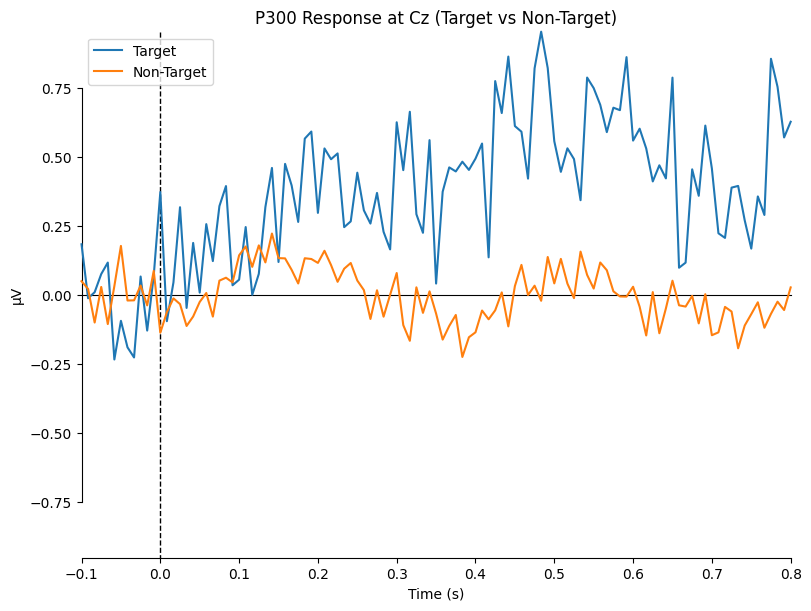

In [ ]:
# 5. Visualize the P300 Response
# Plot the averaged evoked responses, typically focusing on a central parietal electrode like 'Cz' or 'Pz',
# to look for the characteristic P300 component (a positive deflection around 300ms post-stimulus).
# (Example: mne.viz.plot_compare_evokeds for 'Target' vs 'Non-Target' at 'Cz')

# P300 response at Cz
mne.viz.plot_compare_evokeds({'Target': evoc_target, 'Non-Target': evoc_nontarget},
                             picks='Cz', title='P300 Response at Cz (Target vs Non-Target)',
                             show_sensors=False)
plt.show()

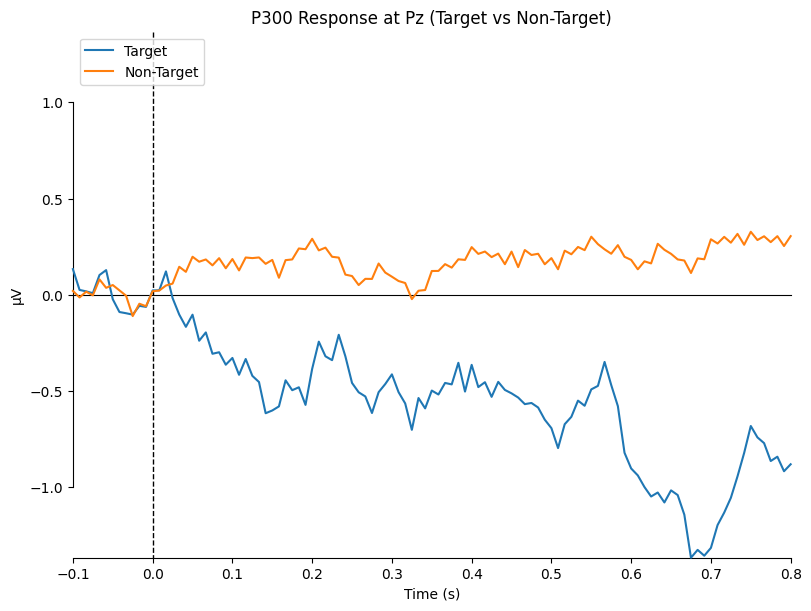

In [ ]:
# 1. Compare Evokeds at Pz
# In addition to Cz, plot the evoked responses at channel 'Pz' (Parietal-central)
# as the P300 component is often prominently observed there.
# (Example: mne.viz.plot_compare_evokeds for 'Target' vs 'Non-Target' at 'Pz')

# P300 response at Pz
mne.viz.plot_compare_evokeds({'Target': evoc_target, 'Non-Target': evoc_nontarget}, picks='Pz', title='P300 Response at Pz (Target vs Non-Target)', show_sensors=False)
plt.show()
